# Install All the Required Packages

In [1]:
# !pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 datasets

In [14]:
# pip install tensorboardX

In [2]:
# !huggingface-cli login

# Create Dataset for Instruction Backtranslation

We load the [andersonbcdefg/guanaco-ai-filtered dataset](https://huggingface.co/datasets/andersonbcdefg/guanaco-ai-filtered) which is a carefully curated subset of the Open Assistant dataset containing only the highest-rated conversation paths from the original dataset, specifically designed for training models to generate instructions based on responses.
It has been filtered to:
* Remove conversations in languages other than English using a fasttext classifier
* Remove conversations where Open Assistant is mentioned, as people training their own chatbots likely do not want their chatbot to think it is named OpenAssistant.

We additionally pre-process the data:
* To includ Single-turn conversations only
* Formatted with Llama 2 chat model prompt instruction tokens
* Response and instruction roles are swapped for reverse fine-tuning

In [1]:
from datasets import load_dataset, Dataset

def transform_conversation(example):
    segments = example['text'].split('###')
    if len(segments) != 3:
        return None

    human = segments[1].replace('Human:', '').strip()
    assistant = segments[2].replace('Assistant:', '').strip()

    if 'Human:' not in segments[1] or 'Assistant:' not in segments[2]:
        return None

    return {'text': f'<s>[INST] {assistant} [/INST] {human} </s>'}

# Load the dataset
dataset = load_dataset('andersonbcdefg/guanaco-ai-filtered')

# Apply the transformation and filter
transformed_data = [
    transform_conversation(example)
    for example in dataset['train']
    if transform_conversation(example) is not None
]

# Create a new dataset from the transformed data
transformed_dataset = Dataset.from_list(transformed_data)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
HF google storage unreachable. Downloading and preparing it from source
Generating train split: 100%|██████████| 2488/2488 [00:00<00:00, 26091.64 examples/s]


# Push the Instruction BackTranslation dataset to HF

In [4]:
transformed_dataset.push_to_hub("guanaco-llama2-reverse-instruct")

# Import All the Required Libraries for fine-tuning Llama2

We would be performing [Q-LoRA fine-tuning](https://huggingface.co/blog/4bit-transformers-bitsandbytes). QLoRA will use a rank of 64 with a scaling parameter of 16. We’ll load the Llama 2 model directly in 4-bit precision using the NF4 type and train it for one epoch

In [2]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

1. Load a llama-2-7b-chat-hf model (chat model)
2. Train it on the Arnab13/guanaco-llama2-reverse-instruct, which will produce our fine-tuned model Llama2-7b-BackInstruct

In [3]:
# The model that you want to train from the Hugging Face hub
model_name = "meta-llama/Llama-2-7b-chat-hf"

# The instruction dataset to use
dataset_name = "Arnab13/guanaco-llama2-reverse-instruct"

# Fine-tuned model name
new_model = "Llama2-7b-BackInstruct"

In [4]:
################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

In [5]:
################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

In [6]:
################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

In [7]:
################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

# Start the fine-tuning process

1. We load the instruction backtranslation dataset 
2. Then, we’re configuring bitsandbytes for 4-bit quantization.
3. Next, we're loading the Llama 2 model in 4-bit precision on a GPU with the corresponding tokenizer.
4. Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!

In [8]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train")

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

Your GPU supports bfloat16: accelerate training with bf16=True


Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.42s/it]
/home/jovyan/.local/lib/python3.10/site-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/home/jovyan/.local/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


In [9]:
# Train model
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
25,1.496100
50,1.518000
75,1.375700
100,1.294400
125,1.475800
150,1.177000


TrainOutput(global_step=162, training_loss=1.4111063333205234, metrics={'train_runtime': 116.1378, 'train_samples_per_second': 5.571, 'train_steps_per_second': 1.395, 'total_flos': 4061995356487680.0, 'train_loss': 1.4111063333205234, 'epoch': 1.0})

In [10]:
# Save trained model
trainer.model.save_pretrained(new_model)

# Let's test out the Instruction Backtranslation model

We will use the text generation pipeline to provide output and check the instruction generated

In [63]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=500)

In [64]:
# Run text generation pipeline with our next model
prompt = '''A penguin and a walrus walk into a bar. The bartender looks up and says, "What is this, some kind of Arctic joke?" The penguin and walrus just look at each other, confused. Then the walrus shrugs and says, "I don't know about Arctic jokes, but we sure know how to break the ice!" The penguin rolls his eyes, but can't help but chuckle.'''

In [65]:
result = pipe(f"<s>[INST] {prompt} [/INST]")

In [66]:
print(prompt)

A penguin and a walrus walk into a bar. The bartender looks up and says, "What is this, some kind of Arctic joke?" The penguin and walrus just look at each other, confused. Then the walrus shrugs and says, "I don't know about Arctic jokes, but we sure know how to break the ice!" The penguin rolls his eyes, but can't help but chuckle.


In [67]:
print(result[0]['generated_text'].split('[/INST]')[-1])

 I want to make a joke about penguins and walruses walking into a bar, but I can't think of anything. Can you help me come up with a joke? 


In [68]:
prompt = '''There are many great canvas libraries for browser JavaScript. Some popular choices include: 1. D3.js: a powerful library for data visualization and creating interactive graphics. 2. Particles.js: a lightweight library for creating particle effects and animations. 3. Three.js: a 3D library for creating interactive and immersive experiences. 4. Konva.js: a high-performance library for creating complex canvas graphics and animations. 5. Paper.js: a vector graphics library for creating complex geometric shapes and animations. 6. Fabric.js: a powerful library for working with SVG and canvas graphics, including support for user interaction. 7. Pixi.js: a fast and lightweight 2D rendering engine for creating interactive graphics and games. 8. Chart.js: a popular library for creating charts and graphs from data. Each library has its own strengths and weaknesses, so the choice of which to use will depend on the specific needs of your project. It's important to research and evaluate each library carefully to ensure that it meets your requirements and fits well with your development workflow.'''

In [69]:
result = pipe(f"<s>[INST] {prompt} [/INST]")

In [70]:
print(prompt)

There are many great canvas libraries for browser JavaScript. Some popular choices include: 1. D3.js: a powerful library for data visualization and creating interactive graphics. 2. Particles.js: a lightweight library for creating particle effects and animations. 3. Three.js: a 3D library for creating interactive and immersive experiences. 4. Konva.js: a high-performance library for creating complex canvas graphics and animations. 5. Paper.js: a vector graphics library for creating complex geometric shapes and animations. 6. Fabric.js: a powerful library for working with SVG and canvas graphics, including support for user interaction. 7. Pixi.js: a fast and lightweight 2D rendering engine for creating interactive graphics and games. 8. Chart.js: a popular library for creating charts and graphs from data. Each library has its own strengths and weaknesses, so the choice of which to use will depend on the specific needs of your project. It's important to research and evaluate each library

In [71]:
print(result[0]['generated_text'].split('[/INST]')[-1])

 What are some great canvas libraries for browser JavaScript? 


##### Observation: Looks like our Backtranslation model does generated relevant instructions

## Push the model to HuggingFace Hub

In [61]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

0

We need to merge the weights from LoRA with the base model.

In [62]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.11s/it]


Our weights are merged and we reloaded the tokenizer. We can now push everything to the Hugging Face Hub to save our model.

In [74]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
model.push_to_hub("Llama2-7b-BackInstruct", check_pr=True)
tokenizer.push_to_hub("Llama2-7b-BackInstruct",check_pr=True)

# Self-Alignment

In [76]:
import random  
from collections import Counter  
from tqdm import tqdm

In [77]:
dataset = load_dataset("GAIR/lima")  
  
# Filter out multi-turn conversations  
train_data = [row for row in dataset['train'] if row["source"] != "multi_turn"]  
  
# Extract instructions and responses  
instructions = [row['conversations'][0] for row in train_data]  
responses = [row['conversations'][1] for row in train_data]  
  
# Calculate the number of tokens  
def num_tokens(text):  
    tokens = tokenizer(text, return_tensors="pt")["input_ids"]  
    return len(tokens[0])  
  
response_token_lengths = [num_tokens(response) for response in responses]  
instruction_token_lengths = [num_tokens(instruction) for instruction in instructions]  

In [80]:
# Calculate quantiles  
sorted_token_lengths = sorted(response_token_lengths)  
lower_bound = sorted_token_lengths[len(sorted_token_lengths) // 4]  
upper_bound = sorted_token_lengths[len(sorted_token_lengths) // 2]  

In [81]:
# Filter based on quantiles and sample 150 items  
filtered_indices = [i for i, length in enumerate(response_token_lengths) if lower_bound <= length <= upper_bound]  
random.seed(42)  
sampled_indices = random.sample(filtered_indices, 150)  

In [87]:
# Generate instructions  
generated_instructions = []  
for i in tqdm(sampled_indices):  
    prompt = responses[i]  
    max_length = response_token_lengths[i] + 80  
    pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=max_length)  
    result = pipe(f"<s>[INST] {prompt} [/INST]")  
    instruction = result[0]['generated_text'].split('[/INST]')[-1].strip()  
    generated_instructions.append(instruction) 

100%|██████████| 150/150 [04:21<00:00,  1.74s/it]


In [88]:
# Collect results into a list of dictionaries  
filtered_data = []  
for idx in sampled_indices:  
    filtered_data.append({  
        'generated_instruction': generated_instructions.pop(0) ,
        'response': responses[idx]
    })  

In [94]:
df=pd.DataFrame(filtered_data)

In [105]:
for i in range(5):
    print('Example no. '+str(i+1)+' \n')
    print('Generated Instruction: ' + df['generated_instruction'].values[i])
    print('Response:' + df['response'].values[i])
    print('\n')

Example no. 1 

Generated Instruction: I want to create a plot using Python. What is the best library to use?
Response:[Matplotlib](https://matplotlib.org/) is arguably the most popular graphing and data visualization library for Python. Below is a working example of using Matplotlib to draw a plot.

First of all, you’ll need to install the Matplotlib package. The easiest way to install matplotlib is to use pip. Type following command in terminal: 
```
pip install matplotlib
```

Now we are ready to draw a line graph, and here is an example of how we can achieve this.

```
# Importing the required module
import matplotlib.pyplot as plt

# Define x-axis and y-axis values
x_values = [1, 2, 3]
y_values = [2, 4, 1]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot the points
ax.plot(x_values, y_values)

# Set x-axis label
ax.set_xlabel('X-Axis')

# Set y-axis label
ax.set_ylabel('Y-Axis')

# Set title
ax.set_title('My First Graph')

# Display the plot
plt.show()

``

In [89]:
# Convert the data to a Hugging Face Dataset  
dataset = Dataset.from_pandas(pd.DataFrame(filtered_data))

In [91]:
dataset.push_to_hub("Arnab13/LIMA-Generated-Instruct")

Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/Arnab13/LIMA-Generated-Instruct/commit/7af0d1c3369da114f8a8b70798730a33fc5b3de2', commit_message='Upload dataset', commit_description='', oid='7af0d1c3369da114f8a8b70798730a33fc5b3de2', pr_url=None, pr_revision=None, pr_num=None)

In [107]:
# Empty VRAM
del model
del pipe
import gc
gc.collect()
gc.collect()

NameError: name 'model' is not defined

# Self Curation

In [163]:
# Load the model and tokenizer
model_name = "meta-llama/Llama-2-7b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]


In [112]:
# Create a pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=1500)

In [122]:
# Evaluation prompt
eval_prompt = """
Below is an instruction from an user and a candidate answer. Evaluate whether or
not the answer is a good example of how AI Assistant should respond to the user’s
instruction. Please assign a score using the following 5-point scale:
1: It means the answer is incomplete, vague, off-topic, controversial, or not
exactly what the user asked for. For example, some content seems missing, numbered
list does not start from the beginning, the opening sentence repeats user’s question.
Or the response is from another person’s perspective with their personal experience
(e.g. taken from blog posts), or looks like an answer from a forum. Or it contains
promotional text, navigation text, or other irrelevant information.
2: It means the answer addresses most of the asks from the user. It does not
directly address the user’s question. For example, it only provides a high-level
methodology instead of the exact solution to user’s question.
3: It means the answer is helpful but not written by an AI Assistant. It addresses
all the basic asks from the user. It is complete and self contained with the
drawback that the response is not written from an AI assistant’s perspective, but
from other people’s perspective. The content looks like an excerpt from a blog post,
web page, or web search results. For example, it contains personal experience or
opinion, mentions comments section, or share on social media, etc.
4: It means the answer is written from an AI assistant’s perspective with a
clear focus of addressing the instruction. It provide a complete, clear, and
comprehensive response to user’s question or instruction without missing or
irrelevant information. It is well organized, self-contained, and written in a
helpful tone. It has minor room for improvement, e.g. more concise and focused.
5: It means it is a perfect answer from an AI Assistant. It has a clear focus on
being a helpful AI Assistant, where the response looks like intentionally written
to address the user’s question or instruction without any irrelevant sentences. The
answer provides high quality content, demonstrating expert knowledge in the area, is
very well written, logical, easy-to-follow, engaging and insightful.
Please first provide a brief reasoning you used to derive the rating score, and
then write "Score: <rating>" in the last line.
"""

In [123]:
# Create lists to store results  
scores = []  
generated_responses = [] 

In [124]:
# Iterate through the dataset  
for i in tqdm(range(len(dataset))):  
    generated_instruction = dataset[i]['generated_instruction']  
    response = dataset[i]['response']  
  
    # Generate text using the pipeline  
    result = pipe(f"<s>[INST] {eval_prompt} Instruction: {generated_instruction} \n Response: {response} [/INST]")  
    gen_text = result[0]['generated_text'].split('[/INST]')[-1].strip()  
    generated_responses.append(gen_text)  
  
    # Extract score if it exists in the response  
    if 'Score: ' in gen_text:  
        scores.append(gen_text.split('Score: ')[-1][0])  
    else:  
        scores.append(None)  # or some default value  

  7%|▋         | 10/150 [01:08<15:53,  6.81s/it]/home/jovyan/.local/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 150/150 [14:50<00:00,  5.94s/it]


In [127]:
# Add the new columns to the dataset  
dataset = dataset.add_column("Score", scores)  
dataset = dataset.add_column("generated_response", generated_responses)  

In [128]:
# Filter out rows with missing scores  
filtered_dataset = dataset.filter(lambda example: example['Score'] is not None)   

Filter: 100%|██████████| 150/150 [00:00<00:00, 44900.49 examples/s]


In [130]:
# Push to Hugging Face Hub  
filtered_dataset.push_to_hub("Arnab13/LIMA-Generated-Instruct-self-curated") 

Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/Arnab13/LIMA-Generated-Instruct-self-curated/commit/0f8b0ed7fab528a101372553c7851bcbe2c83f17', commit_message='Upload dataset', commit_description='', oid='0f8b0ed7fab528a101372553c7851bcbe2c83f17', pr_url=None, pr_revision=None, pr_num=None)

### Printing out High Quality Examples

In [135]:
sorted_dataset = filtered_dataset.sort("Score", reverse=True)
for i in range(5):  
    print(f"Instruction: \n{sorted_dataset[i]['generated_instruction']}")  
    print(f"Response: \n{sorted_dataset[i]['response']}")  
    print(f"Score: {sorted_dataset[i]['Score']}")  
    print("-" * 80)  

Instruction: 
What is the plan that the writer has in mind?  Please give the details of the plan.  What are the steps that the writer will take?  What will be the outcome of the plan?  What are the risks involved in the plan?  What are the consequences of the plan?  Please provide a detailed answer to the above question.
Response: 
He titled his first two works “Rough Draft”.
This time he called it “Completed Draft”.

He let his friend in on the plan when they met up face-to-face.
Firstly, he sent her fake text messages outlining how this time he was "very confident" he knew how to keep his works safe on his PC from ‘hackers’.
He sent a text stating that he would create a handwritten draft that would be fully edited, which he would then type up on his  computer in a few hours on the 25th of May and publish quickly within 24 hours.
It was a win-win situation.
He knew that if the hacker wasn't watching his texts, he would be able to publish his novel.
But if they were, they'd be caught o

### Printing out Low Quality Examples

In [136]:
sorted_dataset = filtered_dataset.sort("Score")
for i in range(5):  
    print(f"Instruction: \n{sorted_dataset[i]['generated_instruction']}")  
    print(f"Response: \n{sorted_dataset[i]['response']}")  
    print(f"Score: {sorted_dataset[i]['Score']}")  
    print("-" * 80) 

Instruction: 
What is the bus doing?
Response: 
I saw the bus screech out of the parking lot, and I knew that my target hoped to evade me by going on a field trip. My arms and legs moved like pistons to propel myself at a speed no human could ever hope to match. As soon as I latched onto it, the bus configured itself into the shape of a spaceship. Before it had so much as risen into the upper atmosphere, I had melted myself into liquid metal and seeped through a window. "Seatbelts, everyone!" a cheery voice at the front of the bus called.
I reformed into my usual police officer shape and pulled out my pistol. "I knew I should have stayed home today!" a nerdy red-haired kid said. After snapping his neck, the other kids cleared out of the aisle so I could get to my target. The woman in question danced her fingers over the controls. "Come on bus, do your stuff!" she said frantically as I approached. I grabbed her by her frizzy red hair as she she tried to shield herself with an overgrown 

In [148]:
df = pd.DataFrame(filtered_dataset)
df.Score.astype(int).value_counts()

Score
3    86
4    26
2    21
1     8
5     7
Name: count, dtype: int64

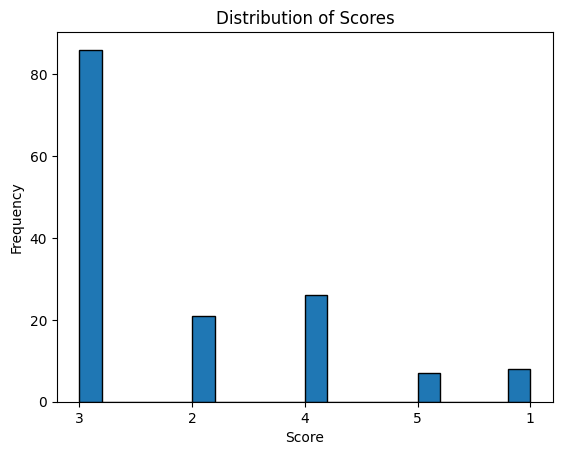

In [140]:
import matplotlib.pyplot as plt  
# Plot the distribution of scores  
filtered_scores = filtered_dataset['Score']  
plt.hist(filtered_scores, bins=20, edgecolor='black')  
plt.title('Distribution of Scores')  
plt.xlabel('Score')  
plt.ylabel('Frequency')  
plt.show() 

In [166]:
# Empty VRAM
del model
del pipe
import gc
gc.collect()
gc.collect()

0

# Fine-tune base model on curated dataset

In [152]:
def filter_scores(example):  
    return example['Score'] is not None and float(example['Score']) >= 3  

In [153]:
curated_dataset = dataset.filter(filter_scores)

Filter: 100%|██████████| 150/150 [00:00<00:00, 39519.20 examples/s]


In [159]:
# Function to concatenate the columns  
def concatenate_columns(example):  
    example['text'] = f"<s>[INST] {example['generated_instruction']} [/INST] {example['response']} </s>"  
    return example  

In [160]:
# Apply the function to the dataset  
curated_dataset = dataset.map(concatenate_columns)  

Map: 100%|██████████| 150/150 [00:00<00:00, 12466.72 examples/s]


In [167]:
# The model that you want to train from the Hugging Face hub
model_name = "meta-llama/Llama-2-7b-chat-hf"
# Fine-tuned model name
new_model = "Llama2-7b-Instruct"

In [169]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=curated_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

Your GPU supports bfloat16: accelerate training with bf16=True


Map: 100%|██████████| 150/150 [00:00<00:00, 5855.89 examples/s]


In [170]:
# Train model
trainer.train()

{'loss': 2.1324, 'learning_rate': 5.773817382593008e-05, 'epoch': 0.66}
{'train_runtime': 33.191, 'train_samples_per_second': 4.519, 'train_steps_per_second': 1.145, 'train_loss': 2.095633255807977, 'epoch': 1.0}


TrainOutput(global_step=38, training_loss=2.095633255807977, metrics={'train_runtime': 33.191, 'train_samples_per_second': 4.519, 'train_steps_per_second': 1.145, 'train_loss': 2.095633255807977, 'epoch': 1.0})

In [171]:
# Save trained model
trainer.model.save_pretrained(new_model)

## Print 5 responses

In [187]:
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)

In [189]:
for i in range(5):
    prompt = curated_dataset[i]['generated_instruction']
    result = pipe(f"<s>[INST] {prompt} [/INST]")
    print('Instruction: '+prompt+'\n')
    print('Response: ' + result[0]['generated_text'].split('[/INST] ')[-1])
    print("-" * 80)  

Instruction: I want to create a plot using Python. What is the best library to use?

Response:  There are several libraries available in Python for creating plots, and the best one for you will depend on your specific needs. Here are some popular options:

1. Matplotlib: Matplotlib is a popular Python library for creating high-quality plots. It is often used for scientific computing, data analysis, and visualization. Matplotlib has a wide range of features, including support for multiple plot types (line, scatter, bar, etc.), customizable colors and fonts, and integration with other Python libraries.
2. Seaborn: Seaborn is a visualization library based on Matplotlib that provides a high-level interface for creating informative and attractive statistical graphics. It is built on top of Matplotlib and provides a more convenient and intuitive way of creating plots.
3. Plotly: Plotly is a library for creating interactive
---------------------------------------------------------------------

# Upload final fine-tuned model to Huggingface hub

In [190]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

0

In [193]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.32s/it]


In [195]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
model.push_to_hub("Llama2-7b-Humpback", check_pr=True)
tokenizer.push_to_hub("Llama2-7b-Humpback",check_pr=True)

pytorch_model-00002-of-00002.bin: 100%|██████████| 3.50G/3.50G [08:08<00:00, 7.17MB/s]   
